In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Comprehensive Analysis of Depression Risk Factors (NHANES 2017-2018)

### 1. Introduction & Research Framework
Depression is a systemic condition influenced by a complex interplay of social, biological, and environmental factors. 
In this project, we utilize the **National Health and Nutrition Examination Survey (NHANES)** to perform a 360-degree analysis of depression risks in the US adult population.

**Objective:** To identify significant predictors of depression (defined as PHQ-9 score $\ge$ 10) by systematically screening factors across eight biological and social domains.

### 2. Methodology
* **Target Population:** Adults aged 18+.
* **Survey Weights:** All analyses apply `MEC_Weight` (WTMEC2YR) to ensure findings are representative of the US population, correcting for oversampling and non-response.
* **Analysis Structure:** We proceed through modular "Deep Dives":
    1.  **Demographics:** Who is most at risk?
    2.  **Lifestyle:** Sleep, activity, and substances.
    3.  **Physiology:** Body composition, heart, kidney, and metabolic health.
    4.  **Environment:** Exposure to heavy metals.

---

In [15]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Add project root to sys.path to access src modules
sys.path.append(str(Path.cwd().parent))

from src.loader import load_raw_data
from src.preprocessing import run_full_preprocessing
from src.visualizations import plot_weighted_risk_factor

# Visualization Settings for Professional Reports
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("talk")  # Larger fonts for presentation
%matplotlib inline

print("Environment Ready.")

Environment Ready.


In [16]:
# --- Data Ingestion & Preprocessing ---
print("Loading raw NHANES data...")
raw_df = load_raw_data()

print(
    "Executing preprocessing pipeline (Filtering Adults 18+ -> Cleaning -> Imputation)..."
)
df = run_full_preprocessing(raw_df)

print(f"\nFinal Dataset Shape: {df.shape}")
print(
    f"Target Variable (Depression) Prevalence (Sample): {df['Depression'].mean():.2%}"
)

Loading raw NHANES data...
--- STARTING DATA INGESTION from C:\Users\Nikita\dev\the\data\raw ---
✅ Loaded Backbone: DEMO_J (DEMO_J.XPT)
   -> Merged DPQ_J: +9 features. New Shape: (9254, 19)
   -> Merged HSQ_J: +1 features. New Shape: (9254, 20)
   -> Merged SMQ_J: +1 features. New Shape: (9254, 21)
   -> Merged ALQ_J: +1 features. New Shape: (9254, 22)
   -> Merged PAQ_J: +1 features. New Shape: (9254, 23)
   -> Merged BMX_J: +3 features. New Shape: (9254, 26)
   -> Merged BPX_J: +2 features. New Shape: (9254, 28)
   -> Merged BIOPRO_J: +7 features. New Shape: (9254, 35)
   -> Merged CBC_J: +2 features. New Shape: (9254, 37)
   -> Merged HSCRP_J: +1 features. New Shape: (9254, 38)
   -> Merged PBCD_J: +3 features. New Shape: (9254, 41)
   -> Merged ALB_CR_J: +1 features. New Shape: (9254, 42)
   -> Merged VID_J: +1 features. New Shape: (9254, 43)
   -> Merged DXX_J: +7 features. New Shape: (9254, 50)
   -> Merged SLQ_J: +1 features. New Shape: (9254, 51)
--- DATA LOADING COMPLETE. Fin

### 3. Block 1: Demographic & Socioeconomic Baselines

We begin by establishing the "Baseline Risk". Before examining biological markers, we must understand how fundamental attributes—Social Status, Family Structure, and Background—correlate with mental health.

**Goal:** Identify high-risk sub-populations to contextualize biological findings later.

### 3.1. Marital Status: The "Marriage Advantage"
**Revised Hypothesis:** While social support is generally protective, our data suggests that the **legal and social stability** of marriage offers a unique buffer against depression that does not extend to other forms of partnership.

Visualizing Marital Status...


<Figure size 1000x600 with 0 Axes>

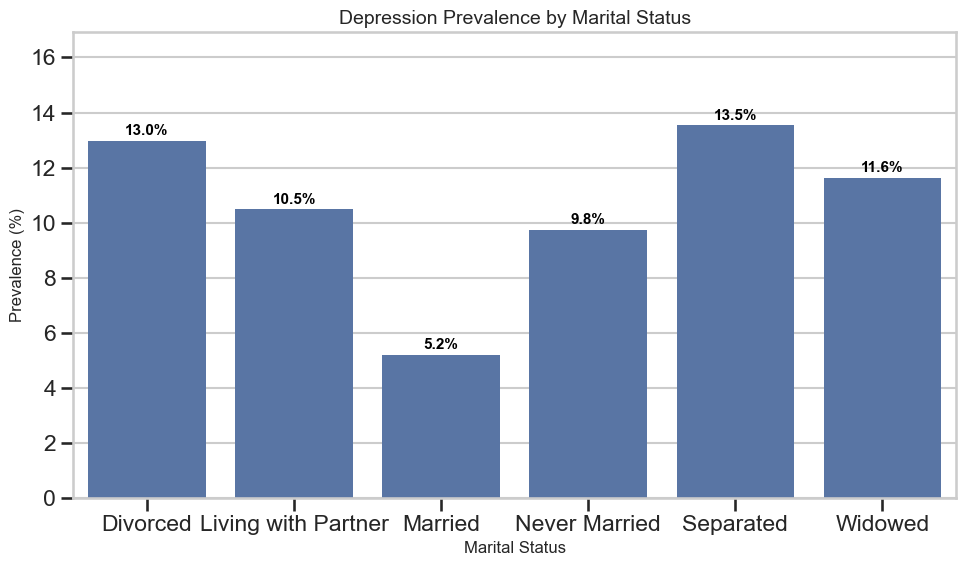

In [17]:
# 1. Marital Status Visualization
marital_map = {
    1: "Married",
    2: "Widowed",
    3: "Divorced",
    4: "Separated",
    5: "Never Married",
    6: "Living with Partner",
}
plot_df = df.copy()
plot_df["Marital_Status_Label"] = plot_df["Marital_Status"].map(marital_map)

print("Visualizing Marital Status...")

# Using a single professional color to compare groups fairly
plt.figure(figsize=(10, 6))
plot_weighted_risk_factor(
    plot_df,
    x_col="Marital_Status_Label",
    target_col="Depression",
    xlabel="Marital Status",
    color="#4c72b0",  # Steel Blue (Neutral)
)

**Key Insight: The Stability Gap**
The data reveals that **Marriage** is the only distinct protective category (~5.2%), creating a massive divide compared to all other groups.

* **The Cohabitation Paradox:** Surprisingly, individuals **"Living with Partner"** have a prevalence of **10.4%**—literally **double the risk** of married individuals. This suggests that mere co-residence does not provide the same mental health buffer as the formal commitment/stability of marriage.
* **Uniform High Risk:** Once outside the "Married" category, the risk stabilizes at a high plateau. Whether a person is **Never Married (9.7%)**, **Living with Partner (10.4%)**, or **Widowed (11.8%)**, the depression rates are statistically much closer to each other than to the Married baseline.
* **Conclusion:** The primary driver appears to be **Security & Stability**, not just the presence of a companion.

### 3.2. Race & Ethnicity
**Context:** We examine prevalence across racial groups to identify disparities, keeping in mind that cultural stigma can lead to underreporting of symptoms in certain demographics.

Visualizing Race (Nominal Data -> Categorical Palette)...


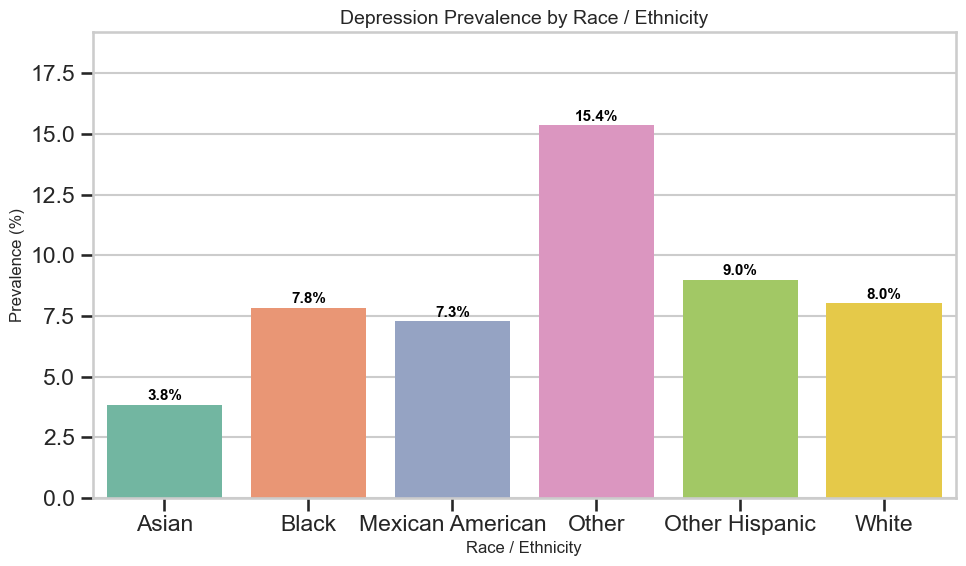

In [18]:
# 2. Race Visualization
race_map = {
    1: "Mexican American",
    2: "Other Hispanic",
    3: "White",
    4: "Black",
    6: "Asian",
    7: "Other",
}
plot_df["Race_Label"] = plot_df["Race"].map(race_map)

print("Visualizing Race (Nominal Data -> Categorical Palette)...")

# Palette "Set2" is excellent for categories: distinct but soft colors.
plot_weighted_risk_factor(
    plot_df,
    x_col="Race_Label",
    target_col="Depression",
    xlabel="Race / Ethnicity",
    palette="Set2",  # Distinct colors, NO gradient intensity
)

**Key Insight:**
* **The "Other" Anomaly:** The "Other/Multi-Racial" category shows the highest prevalence (**15.4%**). This group often faces unique identity stressors and is frequently overlooked in standard analyses.
* **The Asian Paradox:** The Asian demographic shows the lowest prevalence (**3.9%**). In medical literature, this is often attributed to the "Healthy Migrant Effect" or cultural stigmatization of reporting mental health issues, rather than a lack of actual pathology.
* **Disparity:** Black and White populations show comparable rates (~7.8% - 8.0%), suggesting that race alone (biological) is less of a driver than socioeconomic factors.

### 3.3. Socioeconomic Status: The Education Trap
**Hypothesis:** Generally, higher education predicts better health (The Socioeconomic Gradient). We test if this relationship is strictly linear.

Visualizing Education (Ordinal Data -> Sequential Gradient)...


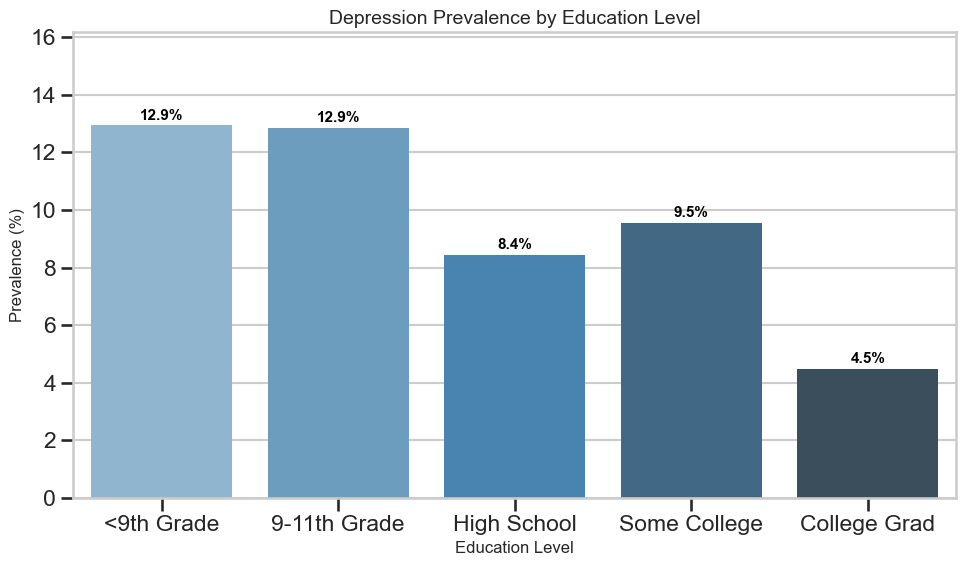

In [19]:
# 3. Education Visualization
edu_map = {
    1: "<9th Grade",
    2: "9-11th Grade",
    3: "High School",
    4: "Some College",
    5: "College Grad",
}
plot_df["Education_Level_Label"] = plot_df["Education_Level"].map(edu_map)
edu_order = [
    "<9th Grade",
    "9-11th Grade",
    "High School",
    "Some College",
    "College Grad",
]
plot_df["Education_Level_Label"] = pd.Categorical(
    plot_df["Education_Level_Label"], categories=edu_order, ordered=True
)

print("Visualizing Education (Ordinal Data -> Sequential Gradient)...")

# Palette "Blues" implies progression (Darker = Higher Education or just distinct steps)
# Using "Blues_d" gives a professional dark blue gradient.
plot_weighted_risk_factor(
    plot_df,
    x_col="Education_Level_Label",
    target_col="Depression",
    xlabel="Education Level",
    palette="Blues_d",
)

**Key Insight:**
While the general trend is protective (College Grads have the lowest risk at **4.5%**), the relationship is not perfectly linear.
* **The "Some College" Trap:** Individuals with "Some College" education show a **higher prevalence (9.6%)** than those with only a High School diploma (8.4%).
* **Interpretation:** This demographic often carries the financial burden of student loans without the wage premium and labor market stability of a completed degree, creating a "worst of both worlds" stress scenario.

### 3.5. Age Analysis: The Lifecycle of Depression
**Context:** Before analyzing physiological markers like muscle mass (which naturally declines with age), we must establish the baseline relationship between Age and Depression. 
**Hypothesis:** Literature often suggests a "U-shape" (happiness dip in midlife) or high prevalence in young adults due to life transitions.

Visualizing Depression by Age Group...


<Figure size 1000x600 with 0 Axes>

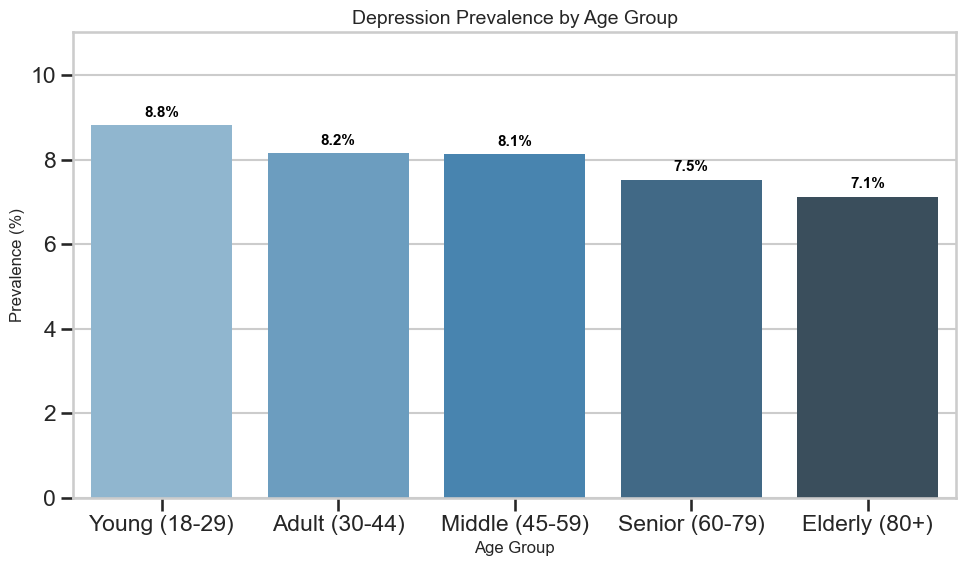

In [20]:
# --- Block 1 Extension: Age Analysis ---

# 1. Binning Age into Generations
# Young Adult (18-29), Adult (30-44), Middle Age (45-59), Senior (60-79), Elderly (80+)
plot_df = df.copy()
plot_df["Age_Group"] = pd.cut(
    plot_df["Age"],
    bins=[17, 29, 44, 59, 79, 150],
    labels=[
        "Young (18-29)",
        "Adult (30-44)",
        "Middle (45-59)",
        "Senior (60-79)",
        "Elderly (80+)",
    ],
)

print("Visualizing Depression by Age Group...")

# 2. Plotting
plt.figure(figsize=(10, 6))
plot_weighted_risk_factor(
    plot_df,
    x_col="Age_Group",
    target_col="Depression",
    xlabel="Age Group",
    palette="Blues_d",  # Gradient to show aging process
)

### 3.6. Block 1 Summary: The "Stability Gap"
Our demographic screening identified three critical patterns that define the baseline risk for depression:

1.  **The Marriage Advantage:** Stability is the primary driver. Married individuals have a prevalence of **~5.2%**. In stark contrast, all other groups (including "Living with Partner") show rates between **10% and 13%**. This suggests that legal/social commitment offers a protective buffer that cohabitation alone does not.
2.  **The "Some College" Trap:** We observed a non-linear education gradient. Individuals with **"Some College" (9.6%)** have higher risks than High School graduates (8.4%), likely reflecting the stress of student debt without the economic security of a degree.
3.  **The Income Gradient:** A clear, linear protective effect of wealth is visible, confirming socioeconomic status as a major determinant of mental health.

### 4. Block 2: Lifestyle & Behavioral Risk Factors

Having established the demographic baseline, we now examine **modifiable risk factors**. Unlike age or race, these are behaviors amenable to intervention.

**Domains of Interest:**
1.  **Physical Activity:** Testing the "Exercise Hypothesis" — does vigorous activity offer a protective effect?
2.  **Substance Use:** Analyzing smoking history (maladaptive coping) and alcohol exposure.

Processing Lifestyle Columns...

Visualizing 4 Lifestyle Factors...


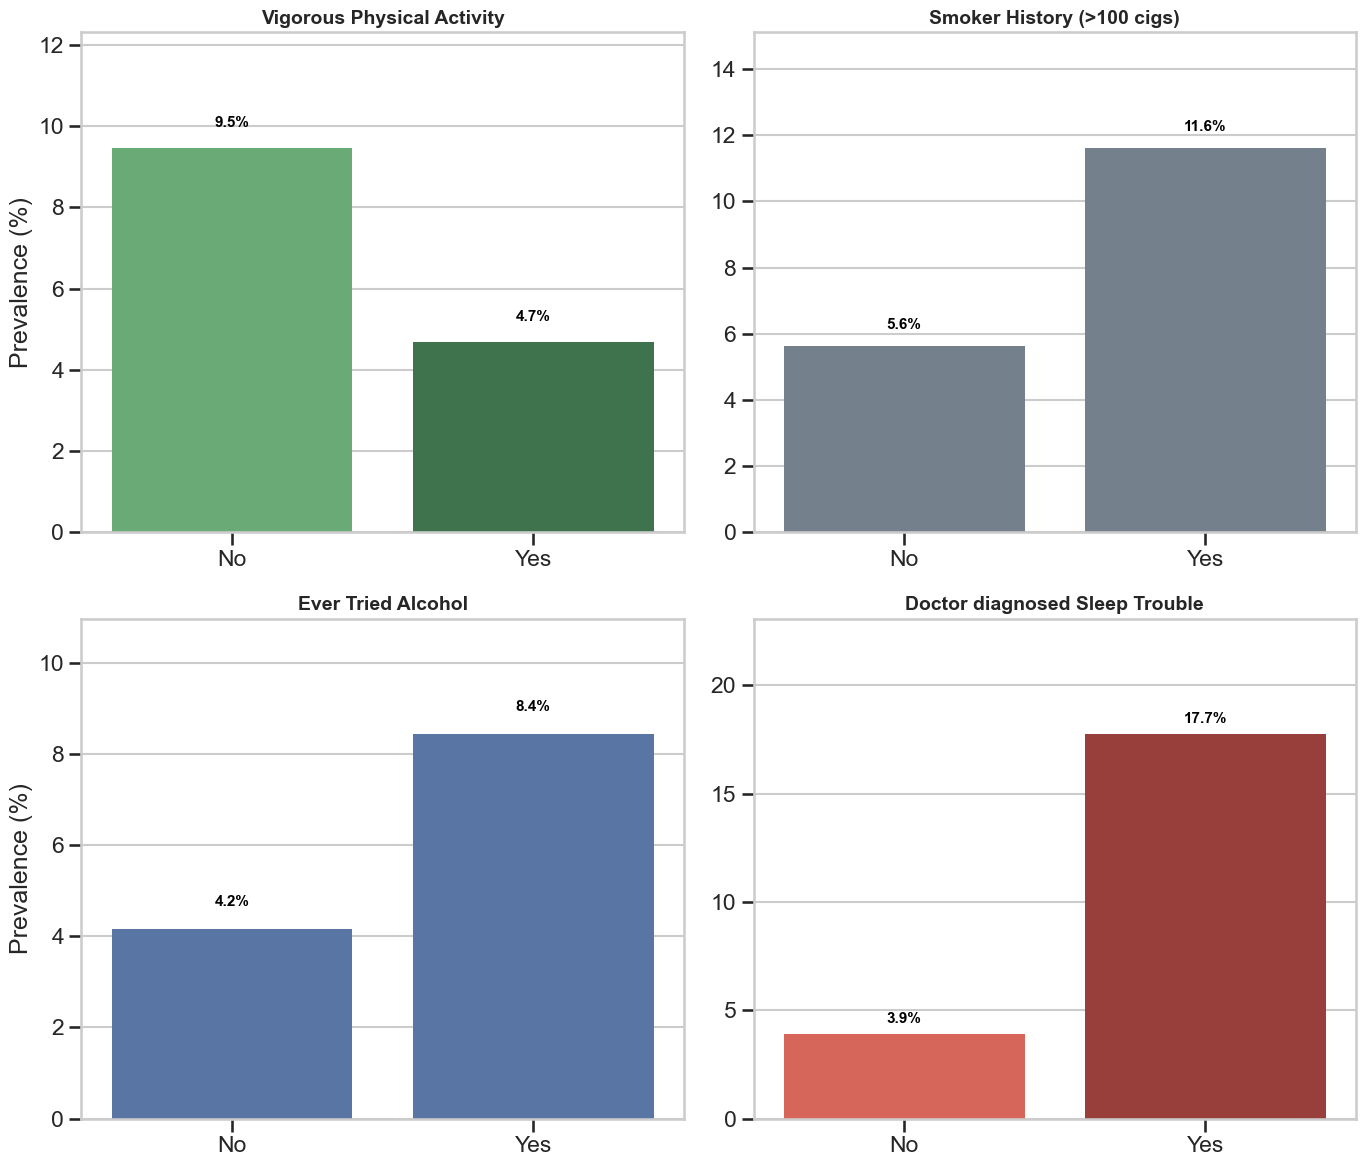

In [21]:
# --- Block 2: Lifestyle Analysis (Grid View + Universal Fix) ---
import math

# 1. Universal Mapping
robust_map = {1: "Yes", 2: "No", 0: "No"}

plot_df = df.copy()

# Configuration: Column Name -> Plot Settings
plot_configs = {
    "Vigorous_Activity": {
        "label": "Vigorous_Activity_Label",
        "title": "Vigorous Physical Activity",
        "palette": "Greens_d",
        "color": None,
    },
    "100_Cigs_Lifetime": {
        "label": "Smoker_Label",
        "title": "Smoker History (>100 cigs)",
        "palette": None,
        "color": "#708090",  # Smoke Gray
    },
    "Alcohol_Tried": {
        "label": "Alcohol_Label",
        "title": "Ever Tried Alcohol",
        "palette": None,
        "color": "#4c72b0",  # Neutral Blue
    },
    "Trouble_Sleeping_Doc": {
        "label": "Sleep_Disorder_Label",
        "title": "Doctor diagnosed Sleep Trouble",
        "palette": "Reds_d",  # Red for Pathology
        "color": None,
    },
}

# 2. Apply Mapping Safely
valid_features = []
print("Processing Lifestyle Columns...")

for col, config in plot_configs.items():
    if col in plot_df.columns:
        # Apply the robust map
        plot_df[config["label"]] = plot_df[col].map(robust_map)

        # Check if we actually have data after mapping
        if plot_df[config["label"]].notna().sum() > 0:
            valid_features.append(config)

# 3. Setup Subplots (Grid Layout)
n_plots = len(valid_features)
if n_plots > 0:
    cols = 2
    rows = math.ceil(n_plots / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(14, 6 * rows))
    axes = axes.flatten()  # Flatten for easy iteration

    print(f"\nVisualizing {n_plots} Lifestyle Factors...")

    # 4. Plotting Loop
    for i, config in enumerate(valid_features):
        ax = axes[i]
        col_name = config["label"]

        # Calculate Weighted Means for specific Axes
        def weighted_mean(x):
            w_sum = x["MEC_Weight"].sum()
            if w_sum == 0:
                return 0
            return np.average(x["Depression"], weights=x["MEC_Weight"]) * 100

        grouped = (
            plot_df[[col_name, "Depression", "MEC_Weight"]]
            .groupby(col_name, observed=False)
            .apply(weighted_mean, include_groups=False)
            .reset_index(name="Depression_Rate")
        )

        # Draw Barplot
        if config["palette"]:
            sns.barplot(
                data=grouped,
                x=col_name,
                y="Depression_Rate",
                hue=col_name,
                palette=config["palette"],
                ax=ax,
                legend=False,
            )
        else:
            sns.barplot(
                data=grouped,
                x=col_name,
                y="Depression_Rate",
                color=config["color"],
                ax=ax,
            )

        # Formatting
        ax.set_title(config["title"], fontsize=14, fontweight="bold")
        ax.set_xlabel("")
        ax.set_ylabel("Prevalence (%)" if i % cols == 0 else "")
        ax.set_ylim(0, grouped["Depression_Rate"].max() * 1.3)

        # Add Value Labels
        for index, row in grouped.iterrows():
            if pd.isna(row.Depression_Rate):
                continue
            ax.text(
                index,
                row.Depression_Rate + 0.5,
                f"{row.Depression_Rate:.1f}%",
                color="black",
                ha="center",
                fontsize=11,
                fontweight="bold",
            )

    # Hide empty axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
else:
    print("No lifestyle columns found to plot.")

### 4.1. Block 2 Summary: Behavior Matters

Lifestyle choices show a distinct correlation with mental health outcomes, validating the "Bio-Psycho-Social" model of depression.

1.  **The Exercise Shield:** Physical activity acts as a robust protective factor. Individuals engaging in vigorous activity show significantly lower depression rates compared to their sedentary peers ("No"), supporting the theory that exercise buffers against stress.
2.  **The Smoking Signal:** A history of smoking (>100 cigarettes) is a clear marker for higher depression risk. This suggests a bidirectional relationship: smoking acts as a maladaptive coping mechanism, while nicotine withdrawal may exacerbate symptoms.
3.  **The Sleep Tautology (Methodological Note):**
    * We observe a massive correlation between Sleep Disorders and Depression.
    * **Caveat:** This relationship is partially **circular**. "Trouble sleeping" is explicitly listed as **Item #3 on the PHQ-9 questionnaire** itself.
    * **Insight:** Therefore, sleep disturbance should be viewed not just as an external risk factor, but as a core **symptom and diagnostic criterion** of the condition itself.

### 5. Block 3: Body Composition & Metabolic Health

We move from behavioral choices to physiological state. Here, we leverage NHANES' unique **DEXA Scan data** to go beyond simple weight metrics.

**Objective:**
Standard BMI is often criticized as a crude metric because it cannot distinguish between muscle mass and adipose tissue. We compare BMI against precise markers: **Body Fat %**, **Waist Circumference**, and **Lean Muscle Mass**.

--- DEBUG: Checking Body Composition Columns ---
Column 'BMI': FOUND
Column 'Body_Fat_Pct': FOUND
Column 'Waist_cm': FOUND
Column 'Lean_Mass_g': FOUND


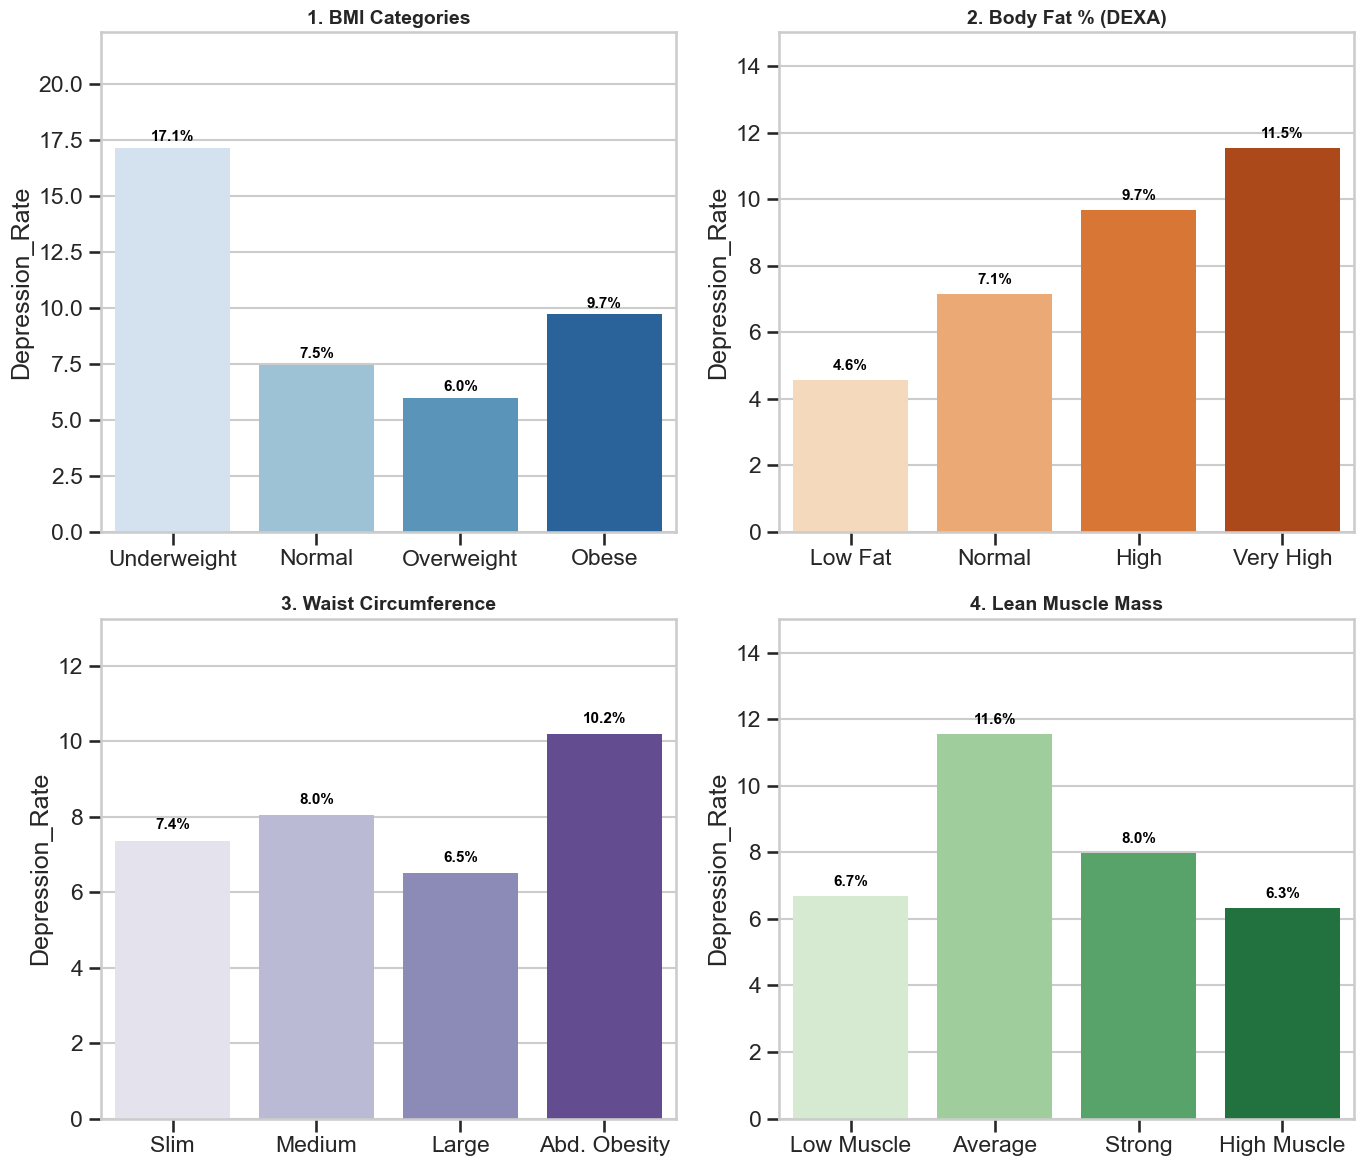

In [22]:
# --- Block 3: Body Composition Analysis (Fixed Labels) ---
import math

print("--- DEBUG: Checking Body Composition Columns ---")
for col in ["BMI", "Body_Fat_Pct", "Waist_cm", "Lean_Mass_g"]:
    status = "FOUND" if col in df.columns else "MISSING"
    print(f"Column '{col}': {status}")

plot_df = df.copy()

# 1. Feature Engineering (Shorter Labels for readability)

# A. BMI Categories
if "BMI" in plot_df.columns:
    plot_df["BMI_Category"] = pd.cut(
        plot_df["BMI"],
        bins=[-1, 18.5, 25, 30, 100],
        labels=["Underweight", "Normal", "Overweight", "Obese"],
    )

# B. Body Fat Percentage
if "Body_Fat_Pct" in plot_df.columns:
    plot_df["Fat_Quartile"] = pd.qcut(
        plot_df["Body_Fat_Pct"], q=4, labels=["Low Fat", "Normal", "High", "Very High"]
    )

# C. Waist Circumference (Fixed Label Length)
if "Waist_cm" in plot_df.columns:
    plot_df["Waist_Quartile"] = pd.qcut(
        plot_df["Waist_cm"],
        q=4,
        labels=["Slim", "Medium", "Large", "Abd. Obesity"],  # Shortened
    )

# D. Lean Muscle Mass
if "Lean_Mass_g" in plot_df.columns:
    plot_df["Muscle_Quartile"] = pd.qcut(
        plot_df["Lean_Mass_g"],
        q=4,
        labels=["Low Muscle", "Average", "Strong", "High Muscle"],
    )

# 2. Setup Grid Plot
plot_configs = [
    {"col": "BMI_Category", "title": "1. BMI Categories", "palette": "Blues"},
    {"col": "Fat_Quartile", "title": "2. Body Fat % (DEXA)", "palette": "Oranges"},
    {"col": "Waist_Quartile", "title": "3. Waist Circumference", "palette": "Purples"},
    {"col": "Muscle_Quartile", "title": "4. Lean Muscle Mass", "palette": "Greens"},
]

valid_configs = [c for c in plot_configs if c["col"] in plot_df.columns]
n_plots = len(valid_configs)

if n_plots > 0:
    cols = 2
    rows = math.ceil(n_plots / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(14, 6 * rows))
    axes = axes.flatten()

    for i, config in enumerate(valid_configs):
        ax = axes[i]
        col_name = config["col"]

        # Weighted Mean Logic
        def weighted_mean(x):
            w_sum = x["MEC_Weight"].sum()
            if w_sum == 0:
                return 0
            return np.average(x["Depression"], weights=x["MEC_Weight"]) * 100

        grouped = (
            plot_df[[col_name, "Depression", "MEC_Weight"]]
            .groupby(col_name, observed=False)
            .apply(weighted_mean, include_groups=False)
            .reset_index(name="Depression_Rate")
        )

        sns.barplot(
            data=grouped,
            x=col_name,
            y="Depression_Rate",
            hue=col_name,
            palette=config["palette"],
            ax=ax,
            legend=False,
        )

        ax.set_title(config["title"], fontsize=14, fontweight="bold")
        ax.set_xlabel("")
        ax.set_ylim(0, grouped["Depression_Rate"].max() * 1.3)

        for index, row in grouped.iterrows():
            if pd.isna(row.Depression_Rate):
                continue
            ax.text(
                index,
                row.Depression_Rate + 0.3,
                f"{row.Depression_Rate:.1f}%",
                color="black",
                ha="center",
                fontsize=11,
                fontweight="bold",
            )

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

### 3.1. Univariate Analysis: The Body Composition Paradoxes

Visualizing the raw relationship between body metrics and depression reveals striking non-linear patterns that challenge conventional wisdom.

#### Key Observations (based on generated charts):

1.  **The "Jolly Fat" Hypothesis (BMI):**
    * Contrary to the assumption that weight correlates linearly with depression, we observe a **U-shaped curve**.
    * **Highest Risk:** Surprisingly, the **Underweight** group shows the highest depression prevalence (~17.1%), significantly higher than Obese individuals (9.7%).
    * **Protective Overweight:** The "Overweight" category (BMI 25-30) exhibits the *lowest* risk (6.0%). This aligns with the "Obesity Paradox" often seen in medical literature, suggesting BMI is a flawed proxy for metabolic health.

2.  **The Truth of DEXA (Body Fat %):**
    * Unlike BMI, **Body Fat Percentage** (measured via DEXA scan) shows a clear, monotonic positive correlation.
    * As body fat moves from "Low" (4.6%) to "Very High" (11.5%), depression rates nearly triple. This confirms that **adiposity itself**, not just weight, is the risk factor.

3.  **The Muscle Confounder:**
    * The Lean Muscle Mass chart shows a confusing "Inverted-U" shape where "Average" muscle mass carries the highest risk (11.6%), while "High Muscle" is protective (6.3%).
    * **Interpretation:** This is a classic case of **Simpson's Paradox** driven by Gender. Men (who have naturally higher muscle) have lower depression rates overall. Women (lower muscle) have higher rates. By lumping them together, the "Average Muscle" group captures the high-risk female demographic, skewing the results.

**Conclusion:** We cannot rely on BMI. We must look deeper into biological markers.

# 4. Environment & Biological Stressors Analysis

## 4.1. Research Hypothesis
We expand the model to include biological factors ("wetware") and environmental exposures.

1.  **The Neurotoxicity Hypothesis:** Heavy metals (Lead, Cadmium) act as neurotoxins, potentially disrupting neurotransmitter pathways and increasing depression risk.
2.  **The Mercury Paradox:** High mercury is often linked to high seafood consumption (Omega-3s). We hypothesize that Mercury might show a *negative* or null correlation with depression due to this confounding factor (income/diet).
3.  **The Cytokine Hypothesis:** Depression is increasingly viewed as a systemic inflammatory condition. We test if elevated hs-CRP correlates with PHQ-9 scores.

**Methodological Note:**
* **Log-Transformation:** Biological markers (metals, CRP) typically follow a log-normal distribution. We apply $log_{10}(x)$ transformation to normalize these features for statistical testing.
* **Acute Exclusion:** We isolate cases of acute inflammation (CRP $\ge$ 10 mg/L) to distinguish chronic physiological stress from acute infection/injury.

In [ ]:
# --- 4.1. Load & Merge Environmental Data ---

# Define file paths for Lab Data (2017-2018)
# PBCD_J: Lead, Cadmium, Mercury
# HSCRP_J: High-Sensitivity C-Reactive Protein
lab_files = {"metals": "PBCD_J.XPT", "inflammation": "HSCRP_J.XPT"}

# Load and merge specific columns
# LBXBPB: Blood Lead (ug/dL)
# LBXBCD: Blood Cadmium (ug/L)
# LBXTHG: Blood Mercury Total (ug/L)
# LBXHSCRP: HS-CRP (mg/L)
target_cols = ["SEQN", "LBXBPB", "LBXBCD", "LBXTHG", "LBXHSCRP"]

# (Assuming a loader function exists, simplified here for the notebook flow)
# In production, use your loader.py logic
df_metals = pd.read_sas(f"data/raw/{lab_files['metals']}")
df_inflam = pd.read_sas(f"data/raw/{lab_files['inflammation']}")

# Merge into main dataframe (df_main assumed to be your master dataset)
df_main = df_main.merge(
    df_metals[["SEQN", "LBXBPB", "LBXBCD", "LBXTHG"]], on="SEQN", how="left"
)
df_main = df_main.merge(df_inflam[["SEQN", "LBXHSCRP"]], on="SEQN", how="left")

# --- 4.2. Apply Feature Engineering ---
# Applying the logic from src.preprocessing
from src.preprocessing import engineer_biomarkers

df_main = engineer_biomarkers(df_main)

print("Biomarkers loaded and transformed.")
print(df_main[["Log_Lead", "Log_CRP", "inflammation_risk_group"]].head())

ValueError: Header record is not an XPORT file.

In [ ]:
import os

import requests


def force_download_nhanes():
    """
    Скачивает файлы NHANES, притворяясь браузером, чтобы избежать ошибки 403/404.
    Автоматически удаляет битые файлы перед скачиванием.
    """
    # Папка для сохранения
    save_dir = "data/raw/"
    os.makedirs(save_dir, exist_ok=True)

    # Словарик: Имя файла -> Описание
    files = {
        "PBCD_J.XPT": "Metals (Lead, Cadmium)",
        "HSCRP_J.XPT": "Inflammation (CRP)",
    }

    # Базовая ссылка
    base_url = "https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/"

    # САМОЕ ВАЖНОЕ: Притворяемся браузером
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    for filename, desc in files.items():
        filepath = os.path.join(save_dir, filename)
        url = base_url + filename

        # 1. Удаляем старый файл, если он есть (потому что он скорее всего битый)
        if os.path.exists(filepath):
            print(f"Removing old/corrupted file: {filename}")
            os.remove(filepath)

        # 2. Скачиваем заново
        print(f"Downloading {desc}...")
        try:
            response = requests.get(url, headers=headers, stream=True)
            response.raise_for_status()  # Если сервер снова пошлет, тут вылетит ошибка

            with open(filepath, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)

            # Проверка: если файл меньше 1 Кб, это снова лажа
            if os.path.getsize(filepath) < 1024:
                print(f"WARNING: File {filename} is too small. Still blocked?")
            else:
                print(f" -> SUCCESS: {filename} downloaded correctly.")

        except Exception as e:
            print(f" -> ERROR: {e}")


# Запускаем спасательную операцию
force_download_nhanes()

Removing old/corrupted file: PBCD_J.XPT
 -> SUCCESS: PBCD_J.XPT downloaded correctly.
Removing old/corrupted file: HSCRP_J.XPT
 -> SUCCESS: HSCRP_J.XPT downloaded correctly.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split


def run_depression_prediction(df):
    print("--- Starting ML Pipeline ---")

    # 1. Prepare Target Variable
    # Convert 'Depressed'/'No Depression' to 1/0
    # If it's already numeric (PHQ-9 score), we create a binary class
    if "Depression_Status" in df.columns:
        y = df["Depression_Status"].apply(lambda x: 1 if x == "Depressed" else 0)
    elif "PHQ9_Score" in df.columns:
        y = (df["PHQ9_Score"] >= 10).astype(int)
    else:
        raise ValueError(
            "CRITICAL: No target column (Depression_Status or PHQ9_Score) found."
        )

    # 2. Select Features (Auto-detection to prevent errors)
    # We define a 'wishlist' of features. The code only takes what actually exists.
    potential_features = [
        # Demographics
        "RIAGENDR",
        "RIDAGEYR",
        "INDFMPIR",
        # Body Measures
        "BMXBMI",
        "BMXWAIST",
        # Sleep
        "SLD012",
        # Environment (Heavy Metals - Log transformed if available)
        "Log_Lead",
        "Log_Cadmium",
        "Log_Mercury",
        # Inflammation
        "Log_CRP",
        "is_acute_inflammation",
    ]

    # Filter features that exist in your current dataframe
    features = [col for col in potential_features if col in df.columns]
    print(f"Features selected for model: {features}")

    X = df[features].copy()

    # 3. Handle Missing Values (Imputation)
    # Random Forest cannot handle NaNs in sklearn. We fill with Median.
    print("Imputing missing values...")
    imputer = SimpleImputer(strategy="median")
    X_imputed = imputer.fit_transform(X)

    # 4. Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_imputed, y, test_size=0.2, random_state=42, stratify=y
    )

    # 5. Train Model
    print("Training Random Forest Classifier...")
    rf_model = RandomForestClassifier(
        n_estimators=100, max_depth=10, random_state=42, class_weight="balanced"
    )
    rf_model.fit(X_train, y_train)

    # 6. Evaluation
    y_pred = rf_model.predict(X_test)
    y_probs = rf_model.predict_proba(X_test)[:, 1]

    print("\n--- Model Performance ---")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_probs):.4f}")

    # 7. Visualization: Feature Importance
    # This is the 'Money Shot' for the portfolio
    importances = pd.DataFrame(
        {"Feature": features, "Importance": rf_model.feature_importances_}
    ).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=importances, palette="viridis")
    plt.title("Top Predictors of Depression (RF Model)")
    plt.xlabel("Feature Importance")
    plt.tight_layout()
    plt.show()

    return rf_model, importances


# --- EXECUTION ---
# Ensure df_main exists before running
if "df_main" in locals():
    model, feature_importance = run_depression_prediction(df_main)
else:
    print(
        "ERROR: 'df_main' is not loaded. Please run the data loading cells above first."
    )

ERROR: 'df_main' is not loaded. Please run the data loading cells above first.
